**Imports**

Data

In [ ]:
#enter the path to get to your CDs_and_Vinyl folder below
PATH_TO_CDS = '../devided_dataset_v2/CDs_and_Vinyl/'

import pandas as pd

# Open and load json training files
x = pd.read_json(PATH_TO_CDS + 'train/review_training.json')
y = pd.read_json(PATH_TO_CDS + 'train/product_training.json')

Other

In [24]:
import numpy as np
from nltk import sentiment
import re
from sklearn.model_selection import cross_validate
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

PATCH TO SPEED UP (ONLY IF INTEL CHIP) 

lmao rip daniel

thanks guys -daniel

In [25]:
from sklearnex import patch_sklearn 

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


**Pre Processing**

In [ ]:
x #770786 entries
y #073082 entries

# Feature creation 

Dropping unverified 

In [4]:
#RUN ONLY IF YOU ARE OK WITH DROPPING UNVERIFIED

dropUnverified = x[x.verified == True]
dropUnverified

,asin,reviewerID,unixReviewTime,vote,verified,reviewTime,style,reviewerName,reviewText,summary,image
0,6673F1740E03573BCD64238FE711FC69,9C856D4A18E1355783B3B28B7ECC1848,1451520000,9,True,"12 31, 2015",{'Format:': ' MP3 Music'},8D88BB79AAC50277AEE82FCFD77F6744,Finding the Beatles all over again - and bette...,I sit listening - with my jaw to the floor - H...,None
4,EF59DAF0C00319A48D4784266FD157EE,2293C9B7950A3356B95828419A677720,1477958400,None,True,"11 1, 2016",{'Format:': ' Audio CD'},C69A09446009C500B1364B7DB5510497,Great cd.,Five Stars,None
7,7809E907572CA5E262E2F418FD8B3C96,981ACFA8D81F7502F5B3D2E3A0C27F6D,1328140800,3,True,"02 2, 2012",{'Format:': ' Audio CD'},0EE688E03E32F5330F598C3416B96B16,I remembered liking this album in the early 70...,Tastes Change,None
8,6673F1740E03573BCD64238FE711FC69,607256A8DAC2F8AC4A7DD9FBE88362AC,1524268800,None,True,"04 21, 2018",{'Format:': ' Audio CD'},7296666D422736895842236214110D08,"I purchased this item, along with the other Be...",Purchased as a birthday gift for my great-nephew,None
9,15385624CFBA7E47876256A65B0E97BD,7FAA7FA54AD97F4381A31B07C7A02BF4,1418169600,None,True,"12 10, 2014",{'Format:': ' Audio CD'},07A5390E52A41D628D2DFB185D372273,as advertized,Four Stars,None
...,...,...,...,...,...,...,...,...,...,...,...
770775,A22DE13554D263912D60A5AC3176A61F,CB4F99C92EE1B0AE289A2D16F35EB887,1522454400,None,True,"03 31, 2018",{'Format:': ' Audio CD'},344A8B9F2DD045C65F9F6F9B75690388,Excellent,Five Stars,None
770778,6673F1740E03573BCD64238FE711FC69,08C5725E6F9C3C3E1C50AF09F9CEC21C,1424736000,2,True,"02 24, 2015",{'Format:': ' Vinyl'},750BD346D389A71848003536E8C765CB,I was a kid when the group broke up and had on...,I must say I have never heard these early albu...,None
770779,151380408EC8DB02F5B800B2369D6744,C4FA68B2E19666D9D4E40D2A49D08716,1418601600,None,True,"12 15, 2014",{'Format:': ' Audio CD'},0D8B93021EA26187591091F3EA26779C,Gave CD to my son,Five Stars,None
770780,AB43432D406F5A9AC547F5416EAB8165,62C775164FDD036277DA68D5993BF020,1466294400,None,True,"06 19, 2016",{'Format:': ' Audio CD'},A7C4CC942F4D7FA6132973E8AE799833,Great CD,Four Stars,None


Making a sample set to test features:

In [ ]:
#ts = test sample 2 thousand long
ts = x[:2000]
ts

Making a single feature ex

In [5]:
reviewCount = x.groupby('asin')["reviewerID"].count()
reviewCount = reviewCount.rename("Review_Count")

In [ ]:
unixReviewMean = x.groupby('asin')['unixReviewTime'].mean()
unixReviewMean

Percent verified

In [6]:


percent_verified = dropUnverified.groupby("asin")["reviewerID"].count()
percent_verified = percent_verified/reviewCount
percent_verified = percent_verified.apply(lambda x: x if x > 0  else 0)
percent_verified = percent_verified.rename("%_Verified")

dropping bots by time of post

All the comments are encoded with the date only, no time, so this is not possible

In [ ]:
# test1 = x[x.unixReviewTime % 100 != 0]
# test1

total number of votes across reviews

In [7]:
x_copy = x
total_review_num = x_copy.vote
total_review_num = total_review_num.apply(lambda x: float(x.replace(",", "")) if type(x) == str  else 0)
total_review_num = total_review_num.rename("vote").to_frame()
x_copy["vote"] = total_review_num["vote"]
total_votes = x_copy.groupby('asin')["vote"].sum("vote")
total_votes = total_votes.rename("Total_Votes")

groupby() testing

In [ ]:
# tests = range(5)
# unique_items = z["asin"].nunique()
# print("ui: ", unique_items)

# asin = z["asin"].values
# print("asin: ",asin)
# avg_votes = np.zeros(len(asin))

# for i in tests: # eventually all
#     item = zgrouped.get_group(asin[i])
#     avg_votes[i] = item["vote"].fillna(0).astype(int).mean()

# print("avg_votes: ", avg_votes[0:5])

Percent of reviews with images

In [8]:
#total = ts.groupby('asin')["reviewerID"].count()
with_image = x[x.image.astype('string') != "None"]
with_image = with_image.groupby('asin')["image"].count()
#print(with_image)
#print(total)
with_image_percentage = with_image/reviewCount
#with_image_percentage = with_image_percentage[with_image_percentage > 0]
with_image_percentage = with_image_percentage.apply(lambda x: x if x > 0  else 0)
# returning rn with NaN instead of 0, not sure if thats fine or not??

#with_image_percentage = with_image_percentage[with_image_percentage > 0]
with_image_percentage = with_image_percentage.rename("%_Image")

Making a feature vector
currently has number of reviews, percentage of reviews with images, percentage of reviews that are verified, and total votes across all reviews

In [ ]:
# feature_vector = reviewCount.rename("Review_NUM")
# feature_vector = feature_vector.to_frame().merge(with_image_percentage.rename("Image_PC").to_frame(), left_index=True, right_index=True)
# feature_vector = feature_vector.merge(percent_verified.rename("Verified_PC").to_frame(), left_index=True, right_index=True)
# # fxx = feature_vector[feature_vector.Image_PC > 0]
# # fxx = 
# feature_vector = feature_vector.merge(total_votes.rename("Total_Votes").to_frame(), left_index=True, right_index=True)
# feature_vector

Since I commented out the feature vector, here are the names of each individual feature:

reviewCount

with_image_percentage

percent_verified

total_votes


Hope this clears it up. lmk if its confusing -Daniel

# Text Analysis

In [ ]:
testdata = x.groupby("asin").get_group("0000B049F5B33CD310EB1AB236E20191")

# np.mean(len(str(testdata["reviewText"]).split()))

Length of Reviews Feature

In [9]:
reviewlength = x.groupby('asin')["reviewText"].apply(lambda x: x.str.split().str.len().mean())
reviewlength = reviewlength.fillna(0).rename("Review_Length")


Percentage Uppercase Feature:

In [14]:
# def count_cap(str):
#     stripped = ''.join(str.split())
#     return sum(c.isupper() for c in ''.join(stripped))/len(stripped)

percentCap = x.groupby('asin')["reviewText"].apply(lambda x: (x.str.count("[A-Z]")/x.str.len()).mean())
percentCap = percentCap.fillna(0).rename("Percent_Uppercase")



Actual Awesomeness Feature: # times the word "awesome" is used per review

In [15]:
actualAwesomeness = x.groupby('asin')["reviewText"].apply(lambda x: (x.str.count("[Aa]wesome")).mean())
actualAwesomeness = actualAwesomeness.fillna(0).rename("Actual_Awesomeness")

# Sentiment Analysis

In [ ]:
## Helper function for sentiment
def review_sentiment(text):
    sia = sentiment.SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)["compound"]

## just some examples to gut check
# print(review_sentiment("Ugh, what a terrible, horrible, no good, very bad day"))
# print(review_sentiment("I went to the store today"))
# print(review_sentiment("I absolutely love my favorite best friend"))

apply sentiment analysis to data

In [16]:
sia = sentiment.SentimentIntensityAnalyzer()
avgSentiment = x.groupby('asin')["reviewText"].apply(lambda x: np.mean(sia.polarity_scores(x.to_string())["compound"]))
avgSentiment = avgSentiment.fillna(0).rename("Avg_Sentiment")

# tests = range(1)
# unique_items = z["asin"].nunique()
# print("ui: ", unique_items)

# asin = z["asin"].unique()
# # print("asin: ",asin[tests])
# avg_votes = np.zeros(len(asin))

# for i in tests: # eventually all
#     item = zgrouped.get_group(asin[i])
#     avg_votes[i] = item["vote"].fillna(0).astype(int).mean()
#     print(len(item))
#     sentiments = map(review_sentiment,item["reviewText"].values[0:1000])
    
#     print(list(sentiments))

# print("avg_votes: ", avg_votes[0:5])


In [ ]:
percentCap.isna().sum()

For reference: What x,y should look like

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

#iris.data
#iris.target

# Testing prep

Put feature vector with col 1 as 'asin' to *z*, answers to *y*

Currently using features:

Name                    |     Column Name

reviewCount                    Review_Count

with_image_percentage          %_Image

percent_verified               %_Verified

total_votes                    Total_Votes

reviewlength                   Review_Length

percentCap                     %_Uppercase

actualAwesomeness              Actual_Awesomeness

avgSentiment                   Avg_Sentiment

In [19]:
#combine all individual features into one dataFrame

#enter any features to be combined here! 
#   They must be pd dataFrames with the 'asin' column for this to work
features = [reviewCount,with_image_percentage,percent_verified,total_votes,avgSentiment,reviewlength,percentCap,actualAwesomeness]

z = x['asin']
for f in features:
    z = pd.merge(z,f,'inner','asin')

#combine resultant data with correct answers 
temp = pd.merge(z,y,'inner','asin') 
temp = temp.groupby("asin").mean()

#split into features (x) and awesomeness (y), which now row correspond but don't have an 'asin' col anymore
# merged_x = temp.drop(['asin','awesomeness'], axis=1)
merged_x = temp.drop(['awesomeness'], axis=1)
merged_y = temp["awesomeness"]

Test example: 

*Gaussian Naive Bayes with tfidf*

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

#split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)

#train and apply tfidf
    # fit = make vocab 
    # transform = turn words -> numbers
x_train = tfidf.fit_transform(x_train).toarray()
x_test = tfidf.transform(x_test).toarray()

#make prediction
y_pred = gnb.fit(x_train, y_train).predict(x_test)

#print accuracy
print(f"Number of mislabeled points out of a total {x_test.shape[0]} points : {(y_test != y_pred).sum()}")

# Models

(choose one)

Support Vector Machine (SVM)

In [36]:
from sklearn import svm

#kernel type
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
kernel = 'rbf'

#if kernel type = 'poly', degree of poly
degree = 3

#whether to enable probability estimates (will slow it down a lot)
probability = True

#tau - penalty for errors is inversely proportional to C
C = 0.5

param_grid = [{'kernel': ['linear','poly','rbf','sigmoid','precomputed'],
            'degree': [2,3,4],
            'C': [0.25,0.5,0.75,1]}]

model = svm.SVC(C=C, kernel=kernel, degree=degree, probability=probability)

Basic Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

Decision Tree

In [29]:
from sklearn import tree

#choose from 'entropy', 'gini', 'log_loss'
criterion = 'entropy'

    ###STOPPING CONDITIONS
#max height/depth of the tree OR None if no limit
max_depth = None

#if sat(N) < n_samples*this, don't try to split it any further
min_samples_split = .01

    ###OTHER
#if min(sat(nodes after a split)) < n_samples*this, split not considered 
#       (aka model isnt allowed to create leaf nodes with < n_samples*this samples)
#       (smooths the model, avoids splits like 2000 -> 1999 vs 1)
min_samples_leaf = .01

param_grid = [{'criterion': ['entropy','gini','log_loss'],
            'max_depth': [None,5,10,15],
            'min_samples_split': [2,0.01,0.05,0.1,0.2],
            'min_samples_leaf':[2,0.01,0.05,0.1,0.2]}]

model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

Decision Tree - See what it looks like! 

(only run if the model is a decision tree)

*note: this trains the model on the whole dataset, so don't do before testing!*

In [ ]:
model.fit(merged_x,merged_y)
tree.plot_tree(model)

K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#number of neighbors
n_neighbors = 5

#do you want proximity to effect influence neighbors have or not
# 'uniform' or 'distance'
weights='uniform'

#leaf size passed to trees
leaf_size=30

param_grid = [{'n_neighbors': [5,7,9,11],
            'weights': ['uniform','distance'],
            'leaf_size':[15,20,25,30]}]

model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, leaf_size=leaf_size, n_jobs=-1)

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

#norm of the penalty
#‘l1’, ‘l2’, ‘elasticnet’, None
penalty = 'l2'

#inverse of regulation strength tau - how much do errors cost?
C = 1.0

#algorithm to compute optimization problem. Probs wont do much other than speed
#‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’
solver = 'lbfgs'

param_grid = [{'penalty': ['l1','l2','elasticnet',None],
            'weights': ['uniform','distance'],
            'C': [0.25,0.5,0.75,1]}]

model = LogisticRegression(penalty=penalty, C=C, solver=solver, n_jobs=-1)

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#number of trees, int
n_estimators=100

#“gini”, “entropy”, “log_loss”
criterion = 'gini'

#max depth of each tree, int or None
max_depth = None

#min % of samples to leave in a branch after a split
min_samples_split = 2

#min % of samples to be a leaf node
min_samples_leaf = 1

param_grid = [{'n_estimators': [50,100,150],
            'criterion': ['gini','entropy','log_loss'],
            'max_depth':[None,10,15,20],
            'min_samples_split':[2,0.01,0.05,0.1,0.2],
            'min_samples_leaf':[1,0.01,0.05,0.1,0.2]}]
            

model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, n_jobs=-1)

# Boosting!
make a model better! goes into *boosted_model*

AdaBoost

In [37]:
from sklearn.ensemble import AdaBoostClassifier

#model to build off of
#estimator = model

#max number of estimators to compute before terminating testing
n_estimators = 10

#weight applied to each classifier at each boosting iteration
learning_rate = 1.0

param_grid = [{'n_estimators': [50,100,150],
            'learning_rate': [1,2,3]}]

boosted_model = AdaBoostClassifier(estimator=model, n_estimators=n_estimators, learning_rate=learning_rate)

Gradient Boosting

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

#loss function to use in boosting process
#‘log_loss’, ‘auto’, ‘binary_crossentropy’, ‘categorical_crossentropy’
loss = 'log_loss'

#shrinkage - multiplicative value for leaves
learning_rate=0.1

#maximum iterations for boosting process
max_iter=100

#maximum leaf nodes/tree
max_leaf_nodes=31

#max depth/tree or None for infinite
max_depth = None

#min samples to be a leaf
min_samples_leaf=20

#regularization parameter, 0 for none
l2_regularization=0

param_grid = [{'loss': ['log_loss','binary_crossentropy'],
            'learning_rate': [0.1,0.3,0.5,0.7,1],
            'max_iter':[50,60],
            'max_leaf_nodes':[25,30,35,40],
            'max_depth':[None,10,15,20],
            'min_samples_leaf':[20,0.01,0.05,0.1,0.2],
            'l2_regularization':[0,0.1,0.2]}]

boosted_model = HistGradientBoostingClassifier(loss=loss, learning_rate=learning_rate, max_iter=max_iter, max_leaf_nodes=max_leaf_nodes, max_depth=max_depth, min_samples_leaf=min_samples_leaf, l2_regularization=l2_regularization)

# Testing

COMBINED NODE FOR TESTING AND PRINTING BC IM LAZY

In [38]:
#desired metrics
scoring=['f1','accuracy','precision','recall']

#number of "folds"
k=10

cv_results = cross_validate(boosted_model, merged_x, merged_y, cv=k, scoring=scoring)

# pretty print results
hline = ("-"*40)

#print means, stdevs
print(hline+"\n\tAVG, STDEV TEST RESULTS\n"+hline)
print("\t\tMEAN\t\tSTDEV")
for m in scoring:
        ind = ("test_"+m)
        test = (m+":").ljust(10)
        print(f"{test}\t{np.round(cv_results[ind].mean(),4)}\t\t{np.round(cv_results[ind].std(),4)}")

K-Fold testing 

(set model to variable *model*)

In [ ]:
#desired metrics
scoring=['f1','accuracy','precision','recall']

#number of "folds"
k=10

cv_results = cross_validate(model, merged_x, merged_y, cv=k, scoring=scoring)

Pretty print results

In [ ]:
hline = ("-"*40)

#print means, stdevs
print(hline+"\n\tAVG, STDEV TEST RESULTS\n"+hline)
print("\t\tMEAN\t\tSTDEV")
for m in scoring:
        ind = ("test_"+m)
        test = (m+":").ljust(10)
        print(f"{test}\t{np.round(cv_results[ind].mean(),4)}\t\t{np.round(cv_results[ind].std(),4)}")


    ##print per test results (if you really want, uncomment)
# print("\n")
# print(hline+"\n\tPER TEST RESULTS\n"+hline)
# for i in range(k):
#     print(f"Test {i}:")
#     for m in scoring:
#         ind = ("test_"+m)
#         test = (m+":").ljust(10)
#         print(f"\t{test} {np.round(cv_results[ind][i],5)}")

Testing Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(merged_x, merged_y, test_size=0.5, random_state=0)

Grid Searching for Best Parameters

must have parameters for variable in *params*

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(model, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
print(grid_search.score(x_train, y_train))

ROC Curve

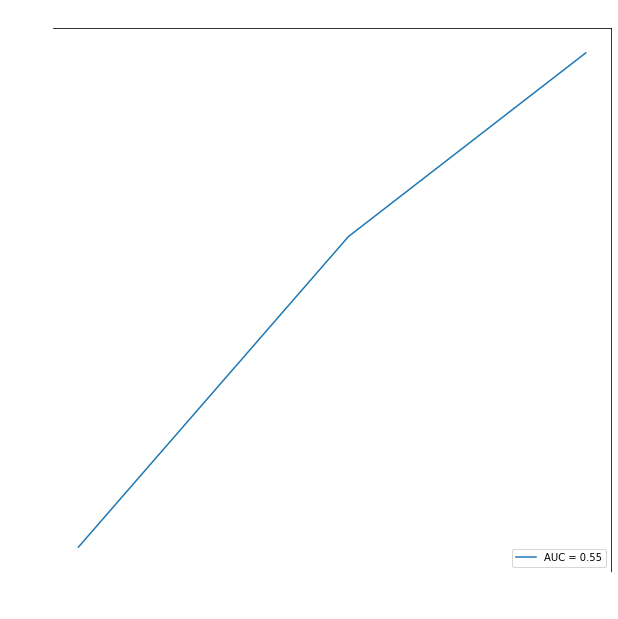

In [ ]:
y_pred = boosted_model.fit(x_train, y_train).predict(x_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
AUROC = metrics.auc(fpr, tpr)

display = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=AUROC)



fig = plt.figure()
ax = fig.add_subplot()
ax.tick_params(axis='x', colors='white') 
ax.tick_params(axis='y', colors='white') 
ax.spines['left'].set_color('white') 
ax.spines['bottom'].set_color('white') 

plt.rcParams['figure.figsize'] = [10, 10]
plt.xlabel("X",fontsize=20, color='white')
plt.ylabel("Y",fontsize=20, color='white')
plt.title("Area Under ROC Curve", fontsize = 20, color='white')

display.plot(ax)

plt.show()